
    Trotter step with Suzuki Trotter (2nd order)
    --------------------------------------------

                      Depth: 15
                 Gate count: 21
        Nonlocal gate count: 8
             Gate breakdown: RZ: 10, CX: 8, RY: 2, RX: 1

    


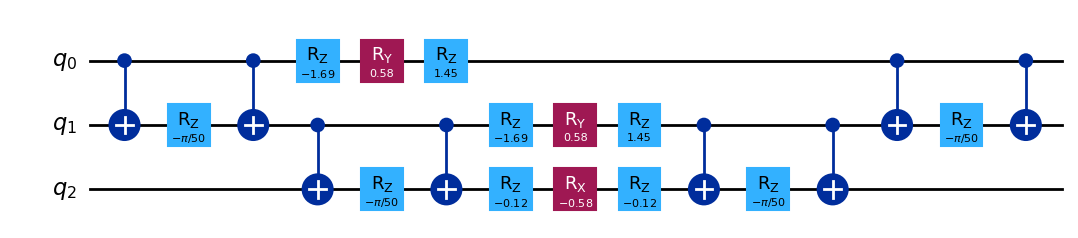

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

from graph_cutter import *
from utils import *

from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator

workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

estimator = MicrosoftEstimator(workspace)

params = estimator.make_params(num_items=1)

second_order_formula = SuzukiTrotter()
L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 
plot_trotter_info(circuit)
circuit.draw('mpl', fold=-1)

In [2]:
# Error budget
params.error_budget = 0.01
params.constraints.max_t_factories = 1
job = estimator.submit(circuit, input_params=params)
r = job.get_results()
Q = r['physicalCounts']['physicalQubits']
T = r['physicalCounts']['runtime']*1e-3
print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)

.......
 total physical qubits required:  6824 
 total runtime 5680.400000000001


In [ ]:
# seeds = range(100,111)
T_factory = range(1,3)
final_Q = Q
final_t = T
overall_T_fact = [0]*len(T_factory)
best_budget = 0.01
# for sed in seeds:
myresult = 0
for _ in range(1):
    subcircuits, g, w = find_cuts(circuit, max_cut=8, plot=False)
    subcircuits = check_estimation_validity(subcircuits)
    print('partition: ',[len(s.data) for s in subcircuits])
    sub_error_budget = error_budget_partition(params.error_budget, len(subcircuits))
    sub_params = estimator.make_params(num_items=len(T_factory))
    print('Sampling Overhead: ', 16**w*9**g)
    best_T_fact = [0]*len(T_factory)
    for edx, e in enumerate(sub_error_budget):
        q = [Q]*len(subcircuits)
        t = [T]*len(subcircuits)
        T_list = [0]*len(subcircuits)
        # print('\n', 'with error budget partition: ', e)
        # print('\n', 'Estimating')
        for sdx, s in enumerate(subcircuits):
            # print(s.data)
            for tdx, tf in enumerate(T_factory):
                sub_params.items[tdx].error_budget = e[sdx]*0.001
                sub_params.items[tdx].constraints.max_t_factories = tf
            job = estimator.submit(s, input_params=sub_params)
            
            r = job.get_results()
            myresult = r
            # myresult
            # break
            q[sdx] = min([r[tdx]['physicalCounts']['physicalQubits'] for tdx in range(len(T_factory))])
            for _index, value in enumerate([r[tdx]['physicalCounts']['physicalQubits'] for tdx in range(len(T_factory))]):
                if  q[sdx] == value:
                    T_list[sdx] = T_factory[_index]
                    t[sdx] = r[_index]['physicalCounts']['runtime']*1e-3
        print(q)
        # print('\n', 'total physical qubits required: ', max(q), '\n', r'total runtime ($\mu$ s): ', sum(t), '\n', 'with T factory:', T_list)
        if max(q) < Q:
            # best_seed = sed
            best_T_fact = T_list
            Q = max(q)
            T = sum(t)
    print('lowest combination: ', 'Max T factories--', best_T_fact, 'total physical qubits--', Q, r'total runtime ($\mu$ s): ', T)
    print('----------------------------------------------------------------')
    print('\n')
    if final_Q > Q:
            # best_seed = sed
            best_budget = e
            overall_T_fact = best_T_fact
            final_Q = Q
            final_t = T
print('\n')
print('----------------------------------------------------------------')
print('lowest combination: error budget--', best_budget, 'Max T factories--', overall_T_fact, 'total physical qubits--', Q, r'total runtime ($\mu$ s): ', T)


In [37]:
subcircuits[2].draw()

┌────────────┐┌─────────────┐┌────────────┐                »
q_0: ──■──┤ Rz(-1.691) ├┤ Ry(0.58049) ├┤ Rz(1.4506) ├────────────────»
     ┌─┴─┐└────────────┘└─────────────┘└────────────┘ ┌────────────┐ »
q_1: ┤ X ├──────■────────────────────────────■────────┤ Rz(-1.691) ├─»
     └───┘    ┌─┴─┐      ┌───────────┐     ┌─┴─┐     ┌┴────────────┴┐»
q_2: ─────────┤ X ├──────┤ Rz(-π/50) ├─────┤ X ├─────┤ Rz(-0.12022) ├»
              └───┘      └───────────┘     └───┘     └──────────────┘»
«                                                                      
«q_0: ────────────────────────────────────────■─────────────────────■──
«     ┌─────────────┐┌────────────┐         ┌─┴─┐    ┌───────────┐┌─┴─┐
«q_1: ┤ Ry(0.58049) ├┤ Rz(1.4506) ├──■──────┤ X ├────┤ Rz(-π/50) ├┤ X ├
«     └─────────────┘└────────────┘┌─┴─┐┌───┴───┴───┐└───────────┘└───┘
«q_2: ─────────────────────────────┤ X ├┤ Rz(-π/50) ├──────────────────
«                                  └───┘└───────────┘

In [ ]:
sub_params = estimator.make_params(num_items=1)
sub_params.items[0].error_budget = 0.01
sub_params.items[0].constraints.max_t_factories = 1
unit = DistillationUnitSpecification()
unit.name = "15-1 RM" # predefined distillation unit

params.distillation_unit_specifications.append(unit)
job = estimator.submit(subcircuits[2], input_params=sub_params)
r = job.get_results()

In [39]:
r

Runtime,4 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 70 logical cycles to run the algorithm. If however the duration of a single T factory (here: 30,800 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,2.73M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (12) (with a logical error rate of 3.00e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,8.98k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 2,904 physical qubits to implement the algorithm logic, and 6,076 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,12,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 3$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 12$ logical qubits."
Algorithmic depth,70,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 10 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 12 multi-qubit measurements for each of the 5 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,926,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 70. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,120,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 12 for each of the 10 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,1,"Number of T factories capable of producing the demanded 120 T states during the algorithm's runtime The total number of T factories 1 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{120 \cdot 30,800\;\text{ns}}{1 \cdot 4,074,400\;\text{ns}}\right\rceil$"
Number of T factory invocations,120,"Number of times all T factories are invoked In order to prepare the 120 T states, the 1 copies of the T factory are repeatedly invoked 120 times."
Physical algorithmic qubits,2.90k,"Number of physical qubits for the algorithm after layout The 2,904 are the product of the 12 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."
